- last two weeks we used all kinds of linear regression models
- including forward stepwise regression, lasso, ridge, and elastic net
- this week we move on to multiple addictive regression models
- such as gradient boosting trees
- other models like random forest, bagging are quite similar


- among them boosting tress are the most famous and powerful
- there are several packages in this filed
- the oldest one is gbm
- the package h2o includes a parallel version of gbm
- and a newer one which has the best performance on kaggle competition is xgboost
- and currently Microsoft developed an even better package called lightgbm
- these week we can try on these models to see whether they can acutally boost our performance


- first we can install lightgbm from the zip file I sent to you
- for linux users maybe you can follow the instruction online, and it would be easier

In [1]:
# https://github.com/Laurae2/lgbdl
# https://github.com/r-dbi/RPostgres/issues/110

In [1]:
from helper import *
from stats import *
from product_info import *
from imp import reload  
import helper
import stats
reload(helper)
reload(stats)

<module 'stats' from 'C:\\Users\\dell\\stats.py'>

In [2]:
import warnings
 
warnings.filterwarnings('ignore')

In [3]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM
## 16

16

In [4]:
product_list = ["bu", "ru", "v", "pp", "l", "jd"]

In [5]:
period = 4096

In [6]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days
## 1066

1066

In [7]:
import dask
from dask import compute, delayed
import sklearn.preprocessing

- fix a bug in week2
- it may affect previous result but the result is still accpetable

In [9]:
split_date = "201910"
train_sample = all_dates<split_date
test_sample = all_dates>split_date
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

In [10]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]
np.append(signal_list, ["ret.4096", "ret.4096.001", "ret.4096.002"])
n_signal = len(signal_list)

In [11]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV
from sklearn.preprocessing import StandardScaler
y_signal = "ret."+str(period)+".004"

- let's begin with week 10
- we can load xgboost and lightgbm at first

In [12]:
import xgboost as xgb
import lightgbm as lgb
import os

In [13]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [14]:
ori_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
signal_names = ori_mat.columns[0:-3]
signal_names
col_names = ori_mat.columns

In [15]:
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
for product in product_list[1:]:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    cur_mat = pd.DataFrame(data=sklearn.preprocessing.scale(cur_mat, with_mean=True), columns=col_names)
    print(product, cur_mat.shape)
    train_mat = train_mat.append(cur_mat)

# ru (4164, 49)
# v (1756, 49)
# pp (2674, 49)
# l (1937, 49)
# jd (1563, 49)





ru (4164, 49)
v (1756, 49)
pp (2674, 49)
l (1937, 49)
jd (1563, 49)


In [16]:
train_std_mat = dict([])
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
train_mat = train_mat[0:0]
test_mat = train_mat
for product in product_list:
    cur_train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    train_std_mat[product] = np.std(cur_train_mat)
    train_mat = train_mat.append(cur_train_mat/train_std_mat[product])
    cur_test_mat = load(HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")
    test_mat = test_mat.append(cur_test_mat/train_std_mat[product])

In [17]:
print(train_mat.shape)
print(test_mat.shape)

# (16094, 49)
# (24087, 49)





(16094, 49)
(24087, 49)


In [18]:
x_train = train_mat.iloc[:, :n_signal].values
y_train = train_mat.loc[:, y_signal].values

In [19]:
strat = "energy.gbm.4096"

- create a directory for the first strate

In [20]:
for product in product_list:
    os.makedirs("e:/intern"+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [21]:
gb1 = GradientBoostingRegressor(random_state=0)
param_grid = {
        'n_estimators': np.arange(10,200,10),
        'max_depth': [3,4,5,6,7,8,9,10],
        'learning_rate':[0.01,0.1],
        'min_samples_leaf': [10,20], 
    
}


In [22]:
%%time
gbm1 = GridSearchCV(gb1, param_grid, n_jobs=CORE_NUM, cv=5);
gbm1.fit(x_train, y_train);

# Wall time: 4h 34min 37s

# GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
#              n_jobs=16,
#              param_grid={'learning_rate': [0.01, 0.1],
#                          'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
#                          'min_samples_leaf': [10, 20],
#                          'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
#        140, 150, 160, 170, 180, 190])})






Wall time: 4h 34min 37s


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=16,
             param_grid={'learning_rate': [0.01, 0.1],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [10, 20],
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])})

In [23]:
x_train.shape

(16094, 45)

In [24]:
print('Gradient boosted tree regression...')
print('Best Params:')
print(gbm1.best_params_)
print('Best CV Score:')
print(gbm1.best_score_)
save(gbm1, HEAD_PATH+"/metal.gbm.4096.pkl")

# Gradient boosted tree regression...
# Best Params:
# {'learning_rate': 0.01, 'max_depth': 8, 'min_samples_leaf': 10, 'n_estimators': 20}
# Best CV Score:
# -0.0002828421285822946


Gradient boosted tree regression...
Best Params:
{'learning_rate': 0.01, 'max_depth': 8, 'min_samples_leaf': 10, 'n_estimators': 20}
Best CV Score:
-0.0002828421285822946


In [25]:
%%time
for product in product_list:
    parLapply(CORE_NUM, all_dates, get_daily_gbm, 
          product=product, signal_list=signal_list, 
          model=gbm1, strat=strat, HEAD_PATH=HEAD_PATH, SAVE_PATH="e:/intern", train_std=np.array(train_std_mat[product][:n_signal]))
;
# Wall time: 53min 6s

Wall time: 53min 6s


''

In [26]:
signal_name = strat
SAVE_PATH = "e:/intern"

In [27]:
%%time
for product in product_list:
    par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH="e:/intern")

## Wall time: 2min 26s

Wall time: 2min 26s


In [28]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    evaluate_signal("energy.gbm", all_dates, product, 2, 20, CORE_NUM, HEAD_PATH, SAVE_PATH,
                    period=4096, split_str=split_date, tranct=tranct, 
                    max_spread=spread+0.1, tranct_ratio=tranct_ratio, atr_filter=0.01, save_path="signal result atr",reverse=1)

# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 16min 20s



reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 16min 20s


pp train sharpe  0.87810887225566 test sharpe  -0.4795506477194235
train sharpe:  0.8781088722556619 test sharpe:  -0.4795506477194255


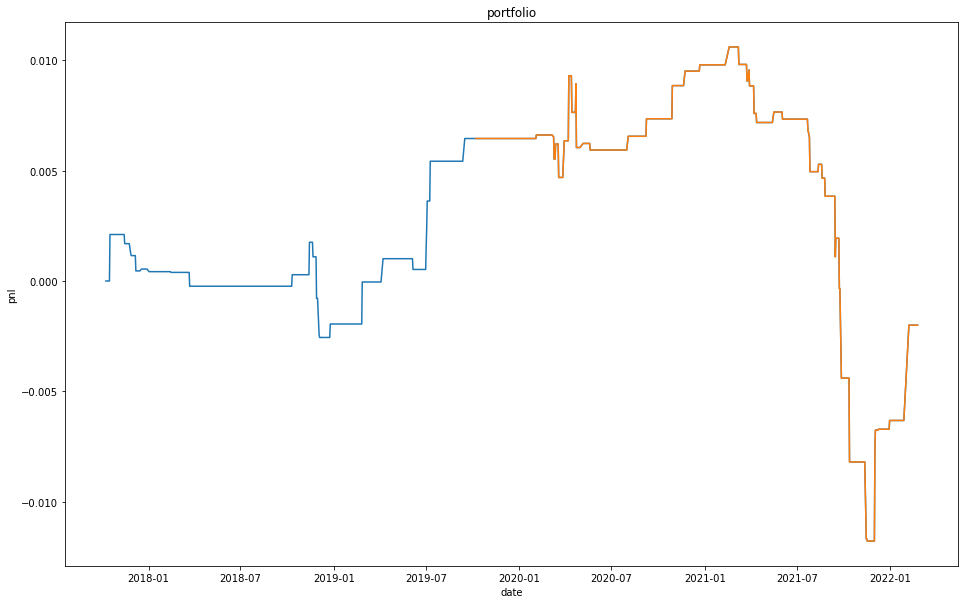

In [29]:
i = 0
strat = "energy.gbm.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
min_pnl = 10
min_num = 10
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    if (sum(good_strat)>0):
        train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        test_stat = signal_stat["test.stat"]
        test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
        test_all_pnl[:,i] = test_pnl
        train_all_pnl[:,i] = train_pnl
        i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))    

# pp train sharpe  0.87810887225566 test sharpe  -0.4795506477194235
# train sharpe:  0.8781088722556619 test sharpe:  -0.4795506477194255


    

- now we can go on with rolling gbm model
- it's added this term of course

In [30]:
month = np.array([file[:6] for file in all_dates])
month_len = np.unique(month, return_counts=True)

In [31]:
## rolling model for gradient boosting machine
## returned value is the training sample standard deviation and the final model
def get_multiple_gbm_roll_model(train_start, train_end, y_signal, forward_len, strat, 
                          product_list, period=4096, SAVE_PATH="e:/intern"):
    cum_daily_ticks = dict([])
    train_tick_start = dict([])
    train_tick_end = dict([])   
    test_tick_start = dict([])
    test_tick_end = dict([])
    for product in product_list:
        cum_daily_ticks[product] = daily_ticks[product].cumsum()
        if train_start==0:
            train_tick_start[product] = 0
        else:
            train_tick_start[product] = int(cum_daily_ticks[product][train_start-1]+1)
        train_tick_end[product] = int(cum_daily_ticks[product][train_end]-1)
        test_tick_start[product] = int(train_tick_end[product]+2)
        test_tick_end[product] = int(cum_daily_ticks[product][train_end+1])
    coef_list = dict([])
    gb1 = GradientBoostingRegressor(random_state=0)
    param_grid = {
            'n_estimators': np.arange(10,100,10),
            'max_depth': [3,4,5],
            'learning_rate':[0.01],
            'min_samples_leaf': [20], 
    }
    model = GridSearchCV(gb1, param_grid, n_jobs=CORE_NUM, cv=5);
    train_mat = np.zeros((0,n_signal))
    y_train = np.array([])
    train_std_mat = dict([])
    y_std = dict([])
    for product in product_list:
        x_train = all_mat[product].iloc[train_tick_start[product]:train_tick_end[product], :n_signal].values
        cur_y_train = all_mat[product][y_signal][train_tick_start[product]:train_tick_end[product]]
        train_std_mat[product] = np.std(x_train)
        y_std[product] = np.std(cur_y_train)
        train_mat = np.append(train_mat,x_train/train_std_mat[product], axis=0)
        y_train = np.append(y_train, cur_y_train/y_std[product])
    model.fit(train_mat, y_train);
    os.makedirs(SAVE_PATH+"/model", exist_ok=True)
    save([train_std_mat, y_std, model], SAVE_PATH+"/model/"+strat+".pkl")
    


In [32]:
test_range = np.where(month_len[0] >= split_date )[0]
print(month_len[0][test_range])
start_month = 0
end_month = sum(month_len[0] < split_date)-1
cum_month_len = np.cumsum(month_len[1])

# ['201910' '201911' '201912' '202001' '202002' '202003' '202004' '202005'
#  '202006' '202007' '202008' '202009' '202010' '202011' '202012' '202101'
#  '202102' '202103' '202104' '202105' '202106' '202107' '202108' '202109'
#  '202110' '202111' '202112' '202201' '202202']





['201910' '201911' '201912' '202001' '202002' '202003' '202004' '202005'
 '202006' '202007' '202008' '202009' '202010' '202011' '202012' '202101'
 '202102' '202103' '202104' '202105' '202106' '202107' '202108' '202109'
 '202110' '202111' '202112' '202201' '202202']


In [33]:
daily_ticks = dict([])
all_mat = dict([])
for product in product_list:
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    daily_ticks[product] = daily_num
    test_mat = load(HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")
    train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    all_mat[product] = pd.concat((train_mat, test_mat))

In [34]:
%%time
#strat = "gbm.4096"
strat = "energy.gbm.4096"
y_signal = "ret.4096.004"
start_month = 0
end_month = sum(month_len[0] < split_date)-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    get_multiple_gbm_roll_model(train_start, train_end, y_signal, forward_len, strat+"."+month_len[0][i_test], 
                          product_list, period=4096, SAVE_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1

# 24 201910
# 25 201911
# 26 201912
# 27 202001
# 28 202002
# 29 202003
# 30 202004
# 31 202005
# 32 202006
# 33 202007
# 34 202008
# 35 202009
# 36 202010
# 37 202011
# 38 202012
# 39 202101
# 40 202102
# 41 202103
# 42 202104
# 43 202105
# 44 202106
# 45 202107
# 46 202108
# 47 202109
# 48 202110
# 49 202111
# 50 202112
# 51 202201
# 52 202202
# Wall time: 2h 19min 50s

24 201910
25 201911
26 201912
27 202001
28 202002
29 202003
30 202004
31 202005
32 202006
33 202007
34 202008
35 202009
36 202010
37 202011
38 202012
39 202101
40 202102
41 202103
42 202104
43 202105
44 202106
45 202107
46 202108
47 202109
48 202110
49 202111
50 202112
51 202201
52 202202
Wall time: 2h 19min 50s


- now we can generate values of each model

In [35]:
def get_daily_gbm(file_name, product, signal_list, model, strat, HEAD_PATH, SAVE_PATH, train_std, y_std, thre=float('Inf')):
    signal_mat = load(SAVE_PATH+"/signal mat pkl/"+product+"/"+file_name).T/train_std
    S = model.predict(signal_mat)*y_std
    S[np.abs(S)>thre] = 0
    save(S, SAVE_PATH+"/tmp pkl/"+product+"/"+strat+"/"+file_name)

In [36]:
%%time
start_month = 0
SAVE_PATH = "e:/intern"
end_month = sum(month_len[0] < split_date)-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    strat_name = strat+"."+month_len[0][i_test]
    [train_std_mat, y_std, model] = load(SAVE_PATH+"/model/"+strat_name+".pkl")
    for product in product_list:
        os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat_name, exist_ok=True)
        parLapply(CORE_NUM,all_dates[train_start:(train_end+forward_len+1)], get_daily_gbm, 
          product=product, signal_list=signal_list, 
          model=model, strat=strat_name, HEAD_PATH=HEAD_PATH, SAVE_PATH="e:/intern", train_std=train_std_mat[product], y_std=y_std[product])
    start_month = start_month+1
    end_month = end_month+1

# 24 201910
# 25 201911
# 26 201912
# 27 202001
# 28 202002
# 29 202003
# 30 202004
# 31 202005
# 32 202006
# 33 202007
# 34 202008
# 35 202009
# 36 202010
# 37 202011
# 38 202012
# 39 202101
# 40 202102
# 41 202103
# 42 202104
# 43 202105
# 44 202106
# 45 202107
# 46 202108
# 47 202109
# 48 202110
# 49 202111
# 50 202112
# 51 202201
# 52 202202
# Wall time: 12h 39min 28s


24 201910
25 201911
26 201912
27 202001
28 202002
29 202003
30 202004
31 202005
32 202006
33 202007
34 202008
35 202009
36 202010
37 202011
38 202012
39 202101
40 202102
41 202103
42 202104
43 202105
44 202106
45 202107
46 202108
47 202109
48 202110
49 202111
50 202112
51 202201
52 202202
Wall time: 12h 39min 28s


In [37]:
%%time
strat = "energy.gbm.4096"
start_month = 0
end_month = sum(month_len[0] < split_date)-1
for i_test in test_range:
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(month_len[0][i_test], all_dates[train_start], all_dates[train_end])
    for product in product_list:
        par_get_all_signal(strat+"."+month_len[0][i_test], all_dates[train_start:(train_end+1)], product, 4096, SAVE_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1

# 201807 20160601.pkl 20180629.pkl
# 201808 20160701.pkl 20180731.pkl
# 201809 20160801.pkl 20180831.pkl
# 201810 20160901.pkl 20180928.pkl
# 201811 20161010.pkl 20181031.pkl
# 201812 20161101.pkl 20181130.pkl
# 201901 20161201.pkl 20181228.pkl
# 201902 20170103.pkl 20190131.pkl
# 201903 20170203.pkl 20190228.pkl
# 201904 20170301.pkl 20190329.pkl
# 201905 20170405.pkl 20190430.pkl
# 201906 20170502.pkl 20190531.pkl
# 201907 20170601.pkl 20190628.pkl
# 201908 20170703.pkl 20190731.pkl
# 201909 20170801.pkl 20190830.pkl
# 201910 20170901.pkl 20190930.pkl
# 201911 20171009.pkl 20191031.pkl
# 201912 20171101.pkl 20191129.pkl
# 202001 20171201.pkl 20191231.pkl
# 202002 20180102.pkl 20200123.pkl
# 202003 20180201.pkl 20200228.pkl
# 202004 20180301.pkl 20200331.pkl
# 202005 20180402.pkl 20200430.pkl
# 202006 20180502.pkl 20200529.pkl
# 202007 20180601.pkl 20200630.pkl
# 202008 20180702.pkl 20200731.pkl
# 202009 20180801.pkl 20200831.pkl
# 202010 20180903.pkl 20200930.pkl
# 202011 20181008.pkl 20201030.pkl
# Wall time: 9min 30s


201910 20171009.pkl 20190930.pkl
201911 20171101.pkl 20191031.pkl
201912 20171201.pkl 20191129.pkl
202001 20180102.pkl 20191231.pkl
202002 20180201.pkl 20200123.pkl
202003 20180301.pkl 20200228.pkl
202004 20180402.pkl 20200331.pkl
202005 20180502.pkl 20200430.pkl
202006 20180601.pkl 20200529.pkl
202007 20180702.pkl 20200630.pkl
202008 20180801.pkl 20200731.pkl
202009 20180903.pkl 20200831.pkl
202010 20181008.pkl 20200930.pkl
202011 20181101.pkl 20201030.pkl
202012 20181203.pkl 20201130.pkl
202101 20190102.pkl 20201231.pkl
202102 20190201.pkl 20210129.pkl
202103 20190301.pkl 20210226.pkl
202104 20190401.pkl 20210331.pkl
202105 20190506.pkl 20210430.pkl
202106 20190603.pkl 20210531.pkl
202107 20190701.pkl 20210630.pkl
202108 20190801.pkl 20210730.pkl
202109 20190902.pkl 20210831.pkl
202110 20191008.pkl 20210930.pkl
202111 20191101.pkl 20211029.pkl
202112 20191202.pkl 20211130.pkl
202201 20200102.pkl 20211231.pkl
202202 20200203.pkl 20220128.pkl
Wall time: 17min 4s


In [38]:
def get_roll_result(product, strat,test_range, month_len, split_date, atr_filter=0, save_path="signal result atr", 
                          HEAD_PATH="d:/intern", SIGNAL_PATH="e:/intern"):
    start_month = 0
    end_month = sum(month_len[0] < split_date)-1
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    spread = product_info[product]["spread"]
    for i_test in test_range:
        forward_len = month_len[1][i_test]
        train_start = 0 if start_month==0 else cum_month_len[start_month-1]
        train_end = cum_month_len[end_month]-1
        strat_name = strat+"."+month_len[0][i_test]
        print(product, i_test, strat_name)
        all_signal = load(SIGNAL_PATH+"/all signal/"+product+"."+strat_name+".pkl")
        open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
        thre_list = []
        for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
            thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
        thre_list = np.array(thre_list)
        thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
        train_result = parLapply(CORE_NUM, all_dates[train_start:(train_end+1)], get_signal_pnl, 
                             product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=tranct, 
                             max_spread=spread*1.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        train_stat = get_hft_summary(train_result, thre_mat, train_end-train_start+1)
        test_result = parLapply(CORE_NUM, all_dates[(train_end+1):(train_end+forward_len+1)], get_signal_pnl, 
                            product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=tranct, 
                             max_spread=spread*1.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        test_stat = get_hft_summary(test_result, thre_mat, forward_len)
        stat_result = OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])    
        save(stat_result, HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        start_month = start_month+1
        end_month = end_month+1


In [39]:
%%time
strat = "energy.gbm.4096"
for product in product_list:
    get_roll_result(product, strat, test_range, month_len, split_date=split_date,atr_filter=0.01)

## Wall time: 3h 51min 43s

bu 24 energy.gbm.4096.201910
bu 25 energy.gbm.4096.201911
bu 26 energy.gbm.4096.201912
bu 27 energy.gbm.4096.202001
bu 28 energy.gbm.4096.202002
bu 29 energy.gbm.4096.202003
bu 30 energy.gbm.4096.202004
bu 31 energy.gbm.4096.202005
bu 32 energy.gbm.4096.202006
bu 33 energy.gbm.4096.202007
bu 34 energy.gbm.4096.202008
bu 35 energy.gbm.4096.202009
bu 36 energy.gbm.4096.202010
bu 37 energy.gbm.4096.202011
bu 38 energy.gbm.4096.202012
bu 39 energy.gbm.4096.202101
bu 40 energy.gbm.4096.202102
bu 41 energy.gbm.4096.202103
bu 42 energy.gbm.4096.202104
bu 43 energy.gbm.4096.202105
bu 44 energy.gbm.4096.202106
bu 45 energy.gbm.4096.202107
bu 46 energy.gbm.4096.202108
bu 47 energy.gbm.4096.202109
bu 48 energy.gbm.4096.202110
bu 49 energy.gbm.4096.202111
bu 50 energy.gbm.4096.202112
bu 51 energy.gbm.4096.202201
bu 52 energy.gbm.4096.202202
ru 24 energy.gbm.4096.201910
ru 25 energy.gbm.4096.201911
ru 26 energy.gbm.4096.201912
ru 27 energy.gbm.4096.202001
ru 28 energy.gbm.4096.202002
ru 29 energy.g

sharpe  -0.5136771820430899


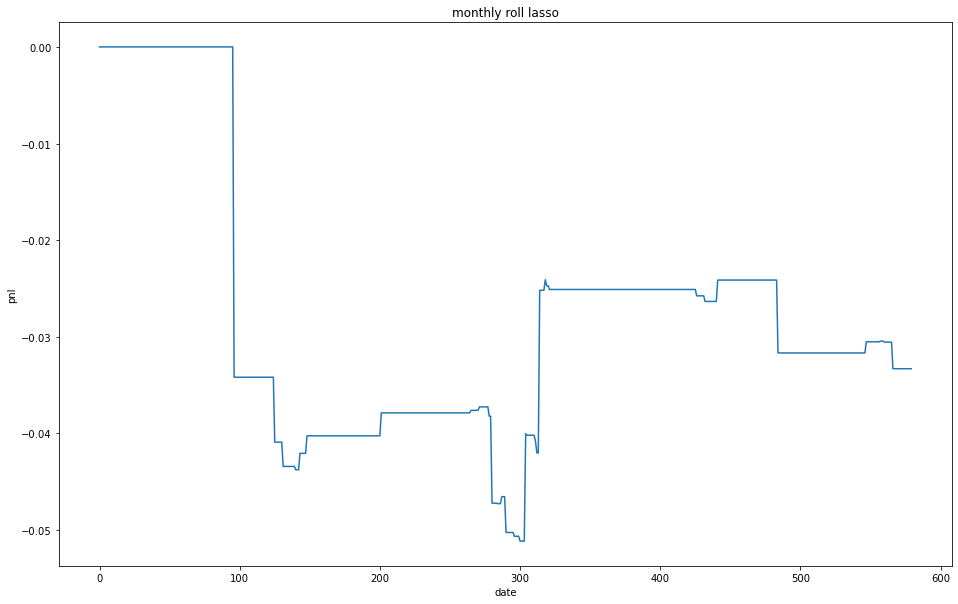

In [40]:
n_product = len(product_list)
save_path = "signal result atr"
strat = "energy.gbm.4096"
start_month = 0
end_month = sum(month_len[0] < split_date)-1
all_pnl = np.array([])
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    strat_name = strat+"."+month_len[0][i_test]
    train_mat = np.zeros((train_end-train_start+1, n_product))
    test_mat = np.zeros((forward_len, n_product))
    for i_product in range(n_product):
        product = product_list[i_product]
        stat_result = load(HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        train_stat = stat_result["train.stat"]
        test_stat = stat_result["test.stat"]
        spread = product_info[product]["spread"]
        good_strat = (train_stat["final.result"]["avg.pnl"]>10*spread)
        train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat) 
        train_pnl[np.isnan(train_pnl)]=0
        train_mat[:,i_product] = train_pnl
        test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        test_pnl[np.isnan(test_pnl)]=0
        test_mat[:,i_product] = test_pnl
    sharpe_mat = np.apply_along_axis(sharpe, 0, train_mat)
    sharpe_weight = zero_divide(sharpe_mat, np.sum(sharpe_mat))
    #parity_weight = risk_parity(train_mat)
    #diagonal_weight = risk_parity(train_mat, only_diag=True)
    #avg_test_pnl = test_mat.mean(axis=1)
    avg_test_pnl = np.dot(test_mat, sharpe_weight)
    #avg_test_pnl = np.dot(test_mat, parity_weight)
    #avg_test_pnl = np.dot(test_mat, diagonal_weight)
    all_pnl = np.append(all_pnl, avg_test_pnl)
    start_month = start_month+1
    end_month = end_month+1
plt.figure(1, figsize=(16, 10))
plt.title("monthly roll lasso")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(all_pnl.cumsum());
print("sharpe ", sharpe(all_pnl))

## sharpe -0.5136771820430899



- Now let's start with xgboost

In [41]:
import xgboost as xgb

- we need to create specific train and test data sets for xgboost

In [42]:
cv_params = {'max_depth': [3,4,5,6,7,8,9,10], 
             'n_estimators': np.arange(10,200,10)}
ind_params = {'learning_rate': 0.1,
              "min_samples_leaf":[10,20],
              'seed':100, 'objective': 'reg:linear'}
xgb_cv = GridSearchCV(xgb.XGBRegressor(**ind_params), 
                            cv_params, 
                            cv = 5, n_jobs = -1) 

In [43]:
%%time
xgb_cv.fit(x_train, y_train);

# Wall time: 36min 36s

# GridSearchCV(cv=5, error_score='raise-deprecating',
#              estimator=XGBRegressor(base_score=0.5, booster='gbtree',
#                                     colsample_bylevel=1, colsample_bytree=1,
#                                     gamma=0, importance_type='gain',
#                                     learning_rate=0.1, max_delta_step=0,
#                                     max_depth=3, min_child_weight=1,
#                                     min_samples_leaf=[10, 20], missing=None,
#                                     n_estimators=100, n_jobs=1, nthread=None,
#                                     objective='reg:linear', random_state=0,
#                                     reg_alpha=0, reg_lambda=1,
#                                     scale_pos_weight=1, seed=100, silent=True,
#                                     subsample=1),
#              iid='warn', n_jobs=-1,
#              param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
#                          'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
#        140, 150, 160, 170, 180, 190])},
#              pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
#              scoring=None, verbose=0)

[04:47:55] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[04:47:55] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Wall time: 36min 36s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    min_samples_leaf=[10, 20], missing=nan,
                                    mon...
                                    n_jobs=None, num_parallel_tree=None,
                                    objective='reg:linear', predictor=None,
                                    random_state=None, reg_alpha=None,
                                   

In [44]:
#best_parameters, score, _ = max(xgb_cv.grid_scorer, key=lambda x: x[1])
xgb_cv.best_params_
## {'max_depth': 3, 'n_estimators': 30}

{'max_depth': 3, 'n_estimators': 30}

In [45]:
strat = "xgb.energy.4096"
signal_name = strat

In [46]:
SAVE_PATH = "e:/intern"
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)


- we can plot them to check the result

In [47]:
train_std_mat = dict([])
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
train_mat = train_mat[0:0]
test_mat = train_mat
for product in product_list:
    cur_train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    train_std_mat[product] = np.std(cur_train_mat)
    train_mat = train_mat.append(cur_train_mat/train_std_mat[product])
    cur_test_mat = load(HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")
    test_mat = test_mat.append(cur_test_mat/train_std_mat[product])

In [48]:
def get_daily_gbm_old(file_name, product, signal_list, model, strat, HEAD_PATH, SAVE_PATH, train_std, thre=float('Inf')):
    signal_mat = load(SAVE_PATH+"/signal mat pkl/"+product+"/"+file_name).T/train_std
    S = model.predict(signal_mat)
    S[np.abs(S)>thre] = 0
    save(S, SAVE_PATH+"/tmp pkl/"+product+"/"+strat+"/"+file_name)

In [49]:
%%time
for product in product_list:
    parLapply(CORE_NUM, all_dates, get_daily_gbm_old, 
          product=product, signal_list=signal_list, 
          model=xgb_cv, strat=strat, HEAD_PATH=HEAD_PATH, SAVE_PATH="e:/intern", train_std=np.array(train_std_mat[product][:n_signal]),)
;
# Wall time: 54min 4s

Wall time: 54min 4s


''

In [50]:
strat

'xgb.energy.4096'

In [51]:
%%time
for product in product_list:
    par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH="e:/intern")
    
#  Wall time: 20min 8s

Wall time: 2min 15s


In [52]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    evaluate_signal("xgb.energy", all_dates, product, 10, 20, CORE_NUM, HEAD_PATH, SAVE_PATH,
                    period=4096, split_str=split_date, tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=0.01, save_path="signal result atr",reverse=1)

# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 19min 23s




reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 19min 23s


bu train sharpe  0.26629909315867895 test sharpe  -1.2049780003350867
ru train sharpe  1.132634612462477 test sharpe  1.3111859421803307
v train sharpe  0.8032428366612385 test sharpe  0.13404744102361166
pp train sharpe  0.5806851905151754 test sharpe  0.47774052258356603
l train sharpe  0.8048833281914874 test sharpe  0.7192840701812405
train sharpe:  1.3848452032124212 test sharpe:  0.16202196308038483


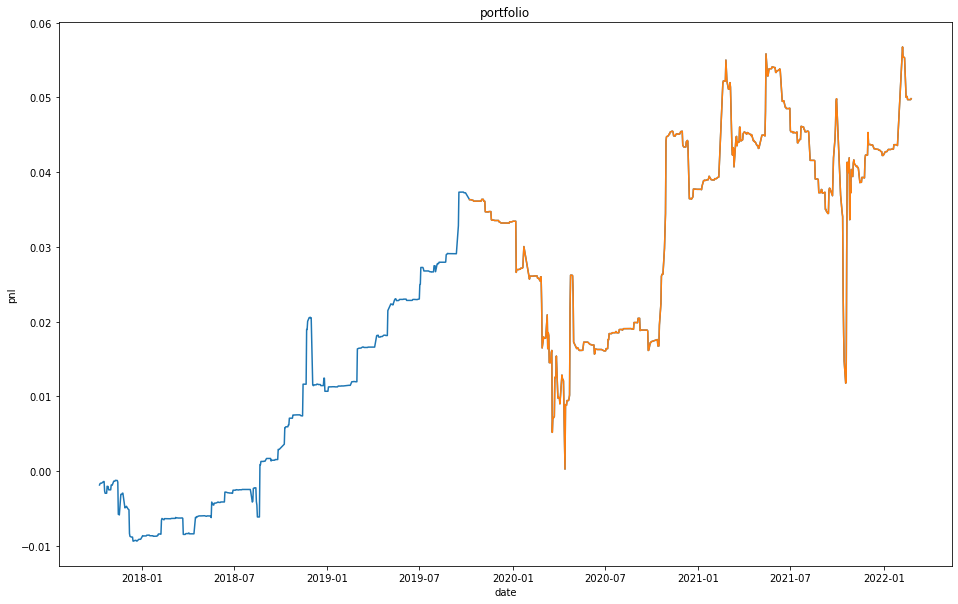

In [53]:
i = 0
strat = "xgb.energy.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list[0:5])])
train_all_pnl = np.zeros([sum(train_sample), len(product_list[0:5])])
min_pnl = 2
min_num = 10
for product in product_list[0:5]:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    if sum(good_strat)>0:
        train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        test_stat = signal_stat["test.stat"]
        test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
        test_all_pnl[:,i] = test_pnl
        train_all_pnl[:,i] = train_pnl
    else:
        train_pnl = np.zeros(np.shape(train_stat["daily.ret"])[0])
        test_stat = signal_stat["test.stat"]
        test_pnl = np.zeros(np.shape(test_stat["daily.ret"])[0])
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))    

# bu train sharpe  0.26629909315867895 test sharpe  -1.2049780003350867
# ru train sharpe  1.132634612462477 test sharpe  1.3111859421803307
# v train sharpe  0.8032428366612385 test sharpe  0.13404744102361166
# pp train sharpe  0.5806851905151754 test sharpe  0.47774052258356603
# l train sharpe  0.8048833281914874 test sharpe  0.7192840701812405
# train sharpe:  1.3848452032124212 test sharpe:  0.16202196308038483






- SUMMARY


- today we compare two tree-based models: gradient boosting machine and xgboost
- but the result is pretty bad
- you can try to tune the parameter to see whether we could improve it